In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#import xgboost as xgb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import mlab
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from google.colab import drive
drive.mount('/content/drive')
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/godaddy-microbusiness-density-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
sample_submission = pd.read_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/sample_submission.csv')
test = pd.read_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/test.csv')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Mounted at /content/drive
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/sample_submission.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/census_starter.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/test.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/epcoh1000.data-00000-of-00001
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/checkpoint
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/train.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/submission.csv


In [ ]:
!pip uninstall xgboost

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.8/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (Y/n)? y
  Successfully uninstalled xgboost-0.90


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.7 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
xgb.__version__

'1.7.3'

In [ ]:
#Train Data
train = pd.read_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/train.csv')
train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])
#extract date from row_id
date = train['row_id'].str.split('_').apply(lambda x:x[1])
year = date.str.split('-').apply(lambda x:x[0])
train['year'] = year
train['year'] = train['year'].astype(int)
#give order to each cfipgs by it's sequence
train['order'] = train.groupby(['cfips'])['row_id'].cumcount()
#Calculate microbusiness_density(Rate of Change) -> price(time n) / price(time n-1)
train['next_month_density'] = train.groupby('cfips')['microbusiness_density'].shift(-1)
train.loc[train[train['order']!=38].index, 'next_month_density'].fillna(1, inplace=True)
train.loc[train[train['order']!=38].index, 'next_month_density'].replace(0,1, inplace=True)
train.loc[train[(train['microbusiness_density']==0)&(train['next_month_density']!=0)&(train['order']!=38)].index, 'microbusiness_density'] = 1
train['target'] = train['next_month_density'] / train['microbusiness_density']
train = train.reset_index(drop=True)
train.loc[train[(train['order']!=38)&(train['target'].isnull())].index,'target'] = 1
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,order,next_month_density,target
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,0,2.884870,0.959167
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,1,3.055843,1.059265
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,2,2.993233,0.979511
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,3,2.993233,1.000000
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,4,2.969090,0.991934
...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,34,1.803249,1.000000
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,35,1.785395,0.990099
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,36,1.785395,1.000000
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,37,1.785395,1.000000


In [ ]:
#Census data from Census Bureau's American Community Survey (ACS)
#Suspended!
census_starter = pd.read_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/census_starter.csv')
census_starter_data = pd.DataFrame(columns=['cfips','year'])
for subject in ['pct_bb','pct_college','pct_foreign_born','pct_it_workers','median_hh_inc']:
    subject_list = [i for i in census_starter.columns if(subject in i)]
    subject_list.insert(0,'cfips')
    subject_tb = census_starter[subject_list].melt(id_vars=["cfips"], var_name="type", value_name=subject)
    subject_tb['year'] = subject_tb['type'].str.split('_').apply(lambda x :x[-1])
    subject_tb = subject_tb[['cfips', 'year', subject]]
    census_starter_data = census_starter_data.merge(subject_tb, on=['cfips', 'year'], how='outer')
#last year census starter mapped to current year of train data
census_starter_data['year'] = (census_starter_data['year'].astype(int)+1)
#Calculate customized rate of change(ROC) for each column in census_starter
def census_diff_func(data, column_lst):
  for column in column_lst:
    column_lag = data.groupby('cfips')[column].shift(1)
    data[f'{column}_diff'] = abs(data[column] - column_lag)/(data[column] + column_lag)
  return data
census_lst = ['pct_bb', 'pct_college', 'pct_foreign_born','pct_it_workers', 'median_hh_inc']
census_starter_data = census_diff_func(census_starter_data, census_lst)
#train = train.merge(census_starter_data, on=['cfips', 'year'], how='left')
census_starter_data

,cfips,year,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,pct_bb_diff,pct_college_diff,pct_foreign_born_diff,pct_it_workers_diff,median_hh_inc_diff
0,1001,2018,76.6,14.5,2.1,1.3,55317.0,NaN,NaN,NaN,NaN,NaN
1,1003,2018,74.5,20.4,3.2,1.4,52562.0,NaN,NaN,NaN,NaN,NaN
2,1005,2018,57.2,7.6,2.7,0.5,33368.0,NaN,NaN,NaN,NaN,NaN
3,1007,2018,62.0,8.1,1.0,1.2,43404.0,NaN,NaN,NaN,NaN,NaN
4,1009,2018,65.8,8.7,4.5,1.3,47412.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15705,56037,2022,88.4,12.4,5.5,1.0,76668.0,0.009709,0.049808,0.028037,0.052632,0.021886
15706,56039,2022,90.5,38.3,11.1,2.0,94498.0,0.007795,0.014570,0.013333,0.142857,0.041008
15707,56041,2022,90.6,12.3,2.9,0.9,75106.0,0.004396,0.012048,0.000000,0.307692,0.017945
15708,56043,2022,85.4,17.2,1.0,1.1,62271.0,0.015458,0.068323,0.375000,0.100000,0.041521


In [ ]:
print('census_starter:',census_starter_data.year.min())
print('census_starter:',census_starter_data.year.max())

census_starter: 2018
census_starter: 2022


In [ ]:
print('Train min date:',train['first_day_of_month'].min())
print('Train max date:',train['first_day_of_month'].max())
print('Test min date:',test['first_day_of_month'].min())
print('Test Max date:',test['first_day_of_month'].max())

Train min date: 2019-08-01 00:00:00
Train max date: 2022-10-01 00:00:00
Test min date: 2022-11-01
Test Max date: 2023-06-01


In [ ]:
#Moving Average of the features : SMA/CMA/EMA
#from time t to (t - num)
def mv_avg(data, column, num):
  data[f'{column}_lag'] = data.groupby('cfips')[column].shift(1)
  data[f'{column}_diff'] = abs(data[column] - data[f'{column}_lag'])/(data[column] + data[f'{column}_lag'])
  column_sma = data.groupby('cfips')[column].rolling(num).mean().reset_index(level=0, drop=True)
  data[f'{column}_SMA'] = column_sma.rename(f'{column}_SMA').reset_index(level=0)[f'{column}_SMA']
  data[f'{column}_SMA_diff'] = abs(data[column] - data[f'{column}_SMA'])/(data[column] + data[f'{column}_SMA'])

  column_cma = data.groupby('cfips')[column].expanding().mean()
  data[f'{column}_CMA'] = column_cma.rename(f'{column}_CMA').reset_index(level=0)[f'{column}_CMA']
  data[f'{column}_CMA_diff'] = abs(data[column] - data[f'{column}_CMA'])/(data[column] + data[f'{column}_CMA'])

  column_ema = data.groupby('cfips')[column].ewm(span=num).mean()
  data[f'{column}_EMA'] = column_ema.rename(f'{column}_EMA').reset_index(level=0)[f'{column}_EMA']
  data[f'{column}_EMA_diff'] = abs(data[column] - data[f'{column}_EMA'])/(data[column] + data[f'{column}_EMA'])
  return data
num = 5
train = mv_avg(train, 'target', num)
#train = mv_avg(train, 'active')

In [ ]:
#target - Customized Change of Rate
target_lag = train.groupby('cfips')['target'].shift(1)
train['target_diff'] = abs(train['target'] - target_lag)/(train['target'] + target_lag)

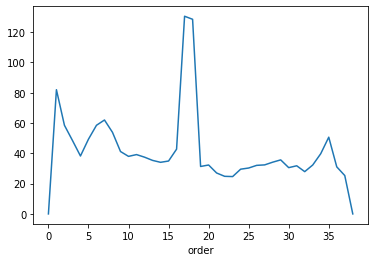

In [ ]:
#原始值
train.groupby('order')['target_diff'].sum().plot()

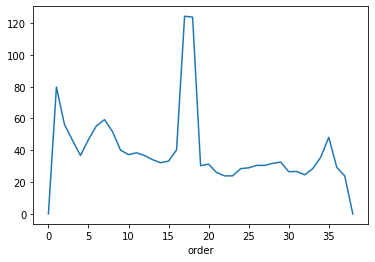

In [ ]:
#移除cfips_over名單
#補上moving average
cfips_over5 = [5145,13061,13287, 18073, 21007, 26095, 28097, 28125, 28129, 29059, 30103,
 31049, 31115, 32027, 37177, 38091, 40141, 46031, 46055,46073, 46107, 47031, 47033, 47153, 
 47175, 48109, 48155,48263, 48311, 48345, 48391]

cfips_over10 = [8031,12001, 13239, 15005, 19143,
 31011, 31171, 32510, 38087, 41023, 46069,51121]
train[~train['cfips'].isin(cfips_over5+cfips_over10)].groupby('order')['target_diff'].sum().plot()

In [ ]:
#Overwrite target values over lower and upper bounds with corresponding EMA target values(time t-1)
lower_bound_percentile = .0125
lower_bound = train['target'].quantile([lower_bound_percentile])[lower_bound_percentile]
upper_bound_percentile = .9875
upper_bound = train['target'].quantile([upper_bound_percentile])[upper_bound_percentile]

outlier = train[(train['target']>upper_bound)|(train['target']<lower_bound)]['cfips'].unique()
print('Number of outliers to be cleansed', outlier.shape[0])
drop_lst = []
for cfips in outlier:
  #Plot Moving Average
  cfips_data = train[train['cfips']==cfips][['target', 'target_SMA', 'target_CMA', 'target_EMA']]
  #cfips_data.plot(label='RELIANCE',figsize=(12, 5))
  idx_lst = cfips_data[(cfips_data['target']>upper_bound)|(cfips_data['target']<lower_bound)].index
  for idx in list(idx_lst)[::-1]:
    if idx == cfips_data.index[0]:
      train.drop(idx, inplace=True)
      print('Drop first row of the cfips')
      drop_lst.append(idx)
    else:
      print('Target value : ', cfips_data.loc[idx-1:idx, 'target'])
      print('SMA ', cfips_data.loc[idx-1, 'target_SMA'])
      print('CMA ', cfips_data.loc[idx-1, 'target_CMA'])
      print('EMA ',cfips_data.loc[idx-1, 'target_EMA'])
      #Overwrite the outlier value of t step with moving average value of t-1 step

      target = train.loc[idx, 'target']
      ma = cfips_data.loc[idx-1, 'target_EMA']
      if ma > upper_bound:
        ma = upper_bound
      elif ma < lower_bound:
        ma = lower_bound
      train.loc[idx, 'target'] = ma
      print('target got replace with t-1 EMA', target, '-->', train.loc[idx, 'target'])

In [ ]:
#target - Customized Change of Rate
target_lag = train.groupby('cfips')['target'].shift(1)
train['target_diff'] = abs(train['target'] - target_lag)/(train['target'] + target_lag)

Text(0.5, 0, 'Quantile')

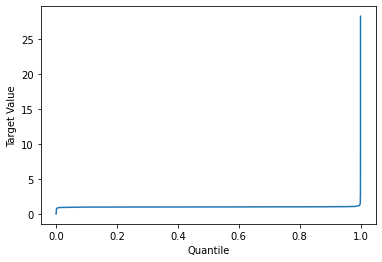

In [ ]:
# Percentile values
interval = list(np.arange(0, 1, 1/train.shape[0]))
d = np.sort(train['target'].quantile(interval))
p = np.array(interval)
plt.plot(p, d)
plt.ylabel('Target Value')
plt.xlabel('Quantile')

In [ ]:
idx = train['target'].isnull()
prediction = train.loc[idx[idx].index]
prediction = prediction.reset_index(drop=True)
train.drop(idx[idx].index, inplace=True)
val = train[train['order']==37]
train.drop(val.index, inplace=True)
train = train.reset_index(drop=True)

In [ ]:
param = {'objective'           :'reg:pseudohubererror',         
        'tree_method'          :'hist',
        'n_estimators'         : 5000,
        'learning_rate'        : 0.02,
        'max_leaves'           : 32,
        'subsample'            : 0.50,
        'colsample_bytree'     : 0.50,
        'max_bin'              : 4096,
        'n_jobs'               : -1,
        'eval_metric'          :'mae',
        #'early_stopping_rounds': 128
        }
model = xgb.XGBRegressor(**param, enable_categorical=True)
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=4096,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=32,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=-1, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor=None, ...)

In [ ]:
feature = list(train.columns)
exclude_lst = ['row_id', 'year', 'cfips', 'first_day_of_month', 'target', 'county', 'active', 'pct_bb', 'pct_college', 'pct_foreign_born','pct_it_workers', 'median_hh_inc',
               'status']
feature = [column for column in feature if column not in exclude_lst]
x_val = val[feature]
y_val = val['target']
train['state'] = train['state'].astype('category')
x_val['state'] = x_val['state'].astype('category')
prediction['state'] = prediction['state'].astype('category')

<ipython-input-157-885e1a2cce70>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['state'] = x_val['state'].astype('category')


In [ ]:
x_train, y_train = train[feature], train['target']
eval_set = [(x_train, y_train), (x_val, y_val)]
model.fit(x_train, y_train, eval_set = eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=4096,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=32,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=-1, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor=None, ...)

In [ ]:
mae_val0 = model.evals_result()['validation_0']['mae']
mae_val1 = model.evals_result()['validation_1']['mae']
epochs = len(mae_val0)
x_axis = range(0, epochs)
print("Minimun of validation set for training : %0.5f" %(min(mae_val0)))
print('Minimun of validation set for testing : %0.5f' %(min(mae_val1)))

Minimun of validation set for training : 0.00434
Minimun of validation set for testing : 0.00455


In [ ]:
#target : Original
#Minimun of validation set for training : 0.00434
#Minimun of validation set for testing : 0.00455

#target : EMA modification 
#Minimun of validation set for training : 0.00222
#Minimun of validation set for testing : 0.00275

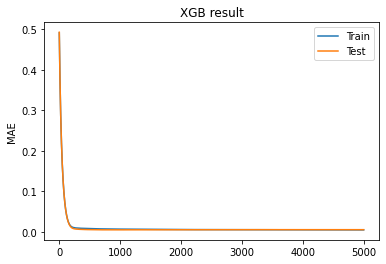

In [ ]:
#original
fig, ax = plt.subplots()
ax.plot(x_axis, mae_val0, label = 'Train')
ax.plot(x_axis, mae_val1, label = 'Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGB result')
plt.show()

In [ ]:
#Feature Importance
pd.DataFrame({'column':feature,'score':model.feature_importances_})

,column,score
0,state,0.018612
1,microbusiness_density,0.012040
2,order,0.029149
3,next_month_density,0.012396
4,target_lag,0.096302
5,target_diff,0.102826
6,target_SMA,0.072413
7,target_SMA_diff,0.071557
8,target_CMA,0.061253
9,target_CMA_diff,0.102948


#Submission

In [ ]:
#Final Submission
submission = pd.DataFrame(columns=['cfips','predict_value'])
for i in range(0,8):
    y_pred = model.predict(prediction[feature])*prediction['microbusiness_density']
    prediction['predict_value'] = y_pred
    submission = submission.append(prediction[['cfips', 'predict_value']])
submission = submission.reset_index(drop=True)
submission.rename(columns={'predict_value':'microbusiness_density'}, inplace=True)
submission['row_id'] = test['row_id']
submission = submission[['row_id', 'microbusiness_density']]
submission.to_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/submission.csv', index=False)

In [ ]:
submission

,row_id,microbusiness_density
0,1001_2022-11-01,3.620764
1,1003_2022-11-01,8.684756
2,1005_2022-11-01,1.272847
3,1007_2022-11-01,1.317922
4,1009_2022-11-01,1.878500
...,...,...
25075,56037_2023-06-01,2.927338
25076,56039_2023-06-01,27.336394
25077,56041_2023-06-01,4.125680
25078,56043_2023-06-01,3.205544
